https://www.radiologycafe.com/medical-students/radiology-basics/ct-overview

Skrypt do sprawdzania w którym oknie znajdują się piksele w jednostkach HU

In [27]:
from pathlib import Path
import numpy as np
from enum import Enum
import Grayscale as gray

import pydicom
from pydicom.pixel_data_handlers.util import apply_modality_lut

In [11]:
class CTWindow(Enum):
    SoftTissueWindow = 0
    LungWindow = 1
    BoneWindow = 2
    GrayscaleWindow = 3

In [16]:
# Przedziały wartości dla poszczególnych typów okna, ważna kolejność!
intervals = {
  CTWindow.GrayscaleWindow: (0, 255),
  CTWindow.SoftTissueWindow: (-125, 225),
  CTWindow.BoneWindow: (-700, 1300),
  CTWindow.LungWindow: (-1200, 800),
}

In [115]:
def check_array_window(array):
    """Function chcecks in which CT window array values are."""
    min_val = np.min(array)
    max_val = np.max(array)
    w = None
    
    # Funkcja sprawdza od najmniejszego przedziału
    for window in intervals:
        lower_bound, upper_bound = intervals[window]
        if (min_val >= lower_bound) & (max_val <= upper_bound):
            w = window
            break
        
    return w     

def cut_to_lung_window(array):
    """Function cuts values outside specified LungWindow interval."""
    lower_bound, upper_bound = intervals[CTWindow.LungWindow]
    
    array = np.where(array < lower_bound, lower_bound, array)
    array = np.where(array > upper_bound, upper_bound, array)
    
    return array

def check_array_window_or_cut(array):
    """Function chcecks in which CT window array values are and cuts to LungWindow if possible."""
    
    ct_window = check_array_window(array)
    
    if ct_window is None or ct_window is CTWindow.BoneWindow:
        array = cut_to_lung_window(array)
        ct_window = check_array_window(array)
    
    return ct_window, array

In [119]:
def check_dicom_lut(file, folder):
    path = Path(folder) / file
    # Get dicom file
    dicomfile = pydicom.dcmread(path)
    # Get pixel array
    image = dicomfile.pixel_array
    # Apply Modality LUT or Rescale Operation
    hu = apply_modality_lut(image, dicomfile)
    
    return hu
    
def check_dicom_lut_windowing(file, folder):
    path = Path(folder) / file
    # Get dicom file
    dicomfile = pydicom.dcmread(path)
    # Get pixel array
    image = dicomfile.pixel_array
    # Apply Modality LUT or Rescale Operation
    hu = apply_modality_lut(image, dicomfile)
    
#     wd = pydicom.pixel_data_handlers.util.apply_voi_lut(hu, dicomfile)
#     wd = pydicom.pixel_data_handlers.util.apply_windowing(hu, dicomfile, index=0)
    width = dicomfile.WindowWidth
    center = dicomfile.WindowCenter
    lower_bound = int(center - width / 2)
    upper_bound = int(center + width / 2)
    array = hu
    array = np.where(array < lower_bound, lower_bound, array)
    array = np.where(array > upper_bound, upper_bound, array)
    
    return array

In [53]:
%matplotlib inline
import matplotlib.pyplot as plt

CTWindow.LungWindow


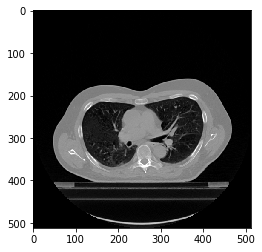

In [121]:
img = check_dicom_lut("1-067.dcm", r"D:\Studia\sem7\inzynierka\aplikacja\images_data\pacjent2_dcm")
ct_window, arr = check_array_window_or_cut(img)
print(ct_window)
plt.imshow(arr, cmap='gray')

CTWindow.LungWindow


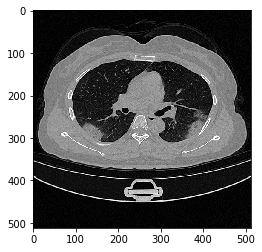

In [122]:
img = check_dicom_lut("ser203img00109.dcm", r"D:\Studia\sem7\inzynierka\aplikacja\images_data")
ct_window, arr = check_array_window_or_cut(img)
print(ct_window)
plt.imshow(arr, cmap='gray')